In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Quantitative Investment Portfolio/Data/'
ff = pd.read_csv(data_dir + 'Fama_french.csv')
ff.dropna(inplace=True)
ff['yyyymm'] = ff.yyyymm.astype(int)

In [ ]:
HOPE = pd.read_parquet(data_dir + 'returns.parquet')
HOPE['date'] = pd.to_datetime(HOPE['yyyymm'],format='%Y%m')
HOPE.head(2)

,permno,yyyymm,ret,lnP,lnsize,hsiccd,date
0,10001,199001,-1.8519,2.296315,9.225832,4925.0,1990-01-01
1,10001,199002,-0.6289,2.290006,9.219523,4925.0,1990-02-01


In [ ]:
def find_missing_dates(group):
    full_range = pd.date_range(start=group['date'].min(), end=group['date'].max(), freq='MS')
    missing_dates = full_range.difference(group['date'])
    return pd.DataFrame({"permno": group['permno'].iloc[0], "missing_date": missing_dates})

In [ ]:
missing_dates_hope = HOPE.groupby('permno')[['permno','date']].apply(find_missing_dates).reset_index(drop=True)
print(f"Dates when there should have been rows but are missing :{100*missing_dates_hope.shape[0]/HOPE.shape[0]:0.1f}%")

Dates when there should have been rows but are missing :10.0%


In [ ]:
l = HOPE.ret.quantile(0.005)
h = HOPE.ret.quantile(0.995)
HOPE['ret'] = HOPE.ret.clip(lower=l,upper=h)

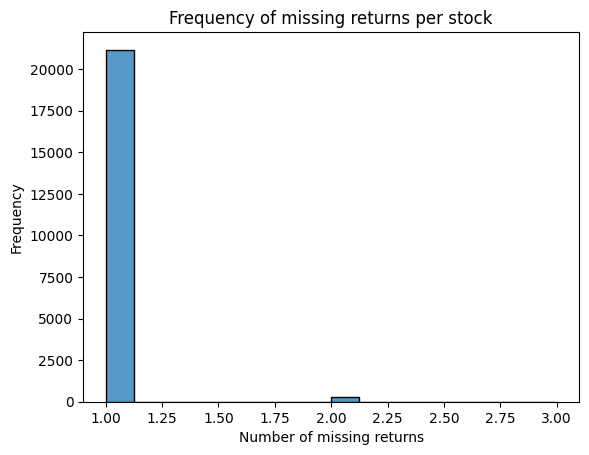

In [ ]:
K = HOPE.groupby('permno')['ret'].apply(lambda x: x.isna().sum())
K = K[K!=0]
sns.histplot(K)
plt.title('Frequency of missing returns per stock')
plt.xlabel('Number of missing returns')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(HOPE.groupby('permno')['ret'].last().isna().sum())
print(HOPE.groupby('permno')['ret'].first().isna().sum())

173
173


In [ ]:
HOPE.set_index('date',inplace=True)
HOPE['fil'] = HOPE.groupby('permno')['ret'].transform('last')
HOPE.loc[HOPE.fil.isna(),'ret'] = 0
HOPE.drop('fil',axis=1,inplace=True)
HOPE.dropna(subset=['ret'],inplace=True)

In [ ]:
HOPE = HOPE.merge(ff[['yyyymm','RF']],on='yyyymm',how='left',validate='many_to_one')
HOPE.loc[:,'excess_ret'] = HOPE.ret - HOPE.RF

In [ ]:
HOPE['lret'] = np.log(1+HOPE.excess_ret/100)*100

In [ ]:
HOPE.head(2)

,permno,yyyymm,ret,lnP,lnsize,hsiccd,RF,excess_ret,lret
0,10001,199001,-1.8519,2.296315,9.225832,4925.0,0.57,-2.4219,-2.451710
1,10001,199002,-0.6289,2.290006,9.219523,4925.0,0.57,-1.1989,-1.206145


In [ ]:
# Due to dates not being consecutive, the returns can't be just shifted and DateOffset and merge is used

In [ ]:
HOPE.sort_values(['permno','yyyymm'],inplace=True)
HOPE['date'] = pd.to_datetime(HOPE.yyyymm,format='%Y%m')
H = HOPE.set_index('date')
H = H.groupby('permno')[['lret','permno']].shift(-1,freq=pd.DateOffset(months=1)).reset_index()
H.rename(columns={'lret':'1m.lret'},inplace=True)
HOPE = HOPE.merge(H,on=['permno','date'],how='left')
del H

In [ ]:
HOPE.head(2)

,permno,yyyymm,ret,lnP,lnsize,hsiccd,RF,excess_ret,lret,date,1m.lret
0,10001,199001,-1.8519,2.296315,9.225832,4925.0,0.57,-2.4219,-2.451710,1990-01-01,-1.206145
1,10001,199002,-0.6289,2.290006,9.219523,4925.0,0.57,-1.1989,-1.206145,1990-02-01,0.623850


In [ ]:
HOPE = HOPE.sort_values(['permno', 'date'])

In [ ]:
def process_group(group,win,ret):

    idx = pd.date_range(start=group['date'].min(),end=group['date'].max(),freq='MS')

    rest = (group.set_index('date')[ret].reindex(idx, fill_value=0).iloc[::-1].rolling(window=win, min_periods=1).sum()[::-1])

    name = str(win)+'m.lret'
    return group.set_index('date').assign(**{name:rest}).reset_index()

In [ ]:
HOPE = HOPE.groupby('permno', group_keys=False).apply(process_group, win=6,ret='1m.lret',include_groups=True)
HOPE = HOPE.groupby('permno', group_keys=False).apply(process_group, win=12,ret='1m.lret',include_groups=True)

<ipython-input-29-30cb6162f5d0>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  HOPE = HOPE.groupby('permno', group_keys=False).apply(process_group, win=6,ret='1m.lret',include_groups=True)
<ipython-input-29-30cb6162f5d0>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  HOPE = HOPE.groupby('permno', group_keys=False).apply(process_group, win=12,ret='1m.lret',include_groups=True)


In [ ]:
HOPE.head(2)

,date,permno,yyyymm,ret,lnP,lnsize,hsiccd,RF,excess_ret,lret,1m.lret,6m.lret,12m.lret
0,1990-01-01,10001,199001,-1.8519,2.296315,9.225832,4925.0,0.57,-2.4219,-2.451710,-1.206145,-0.595824,-5.234258
1,1990-02-01,10001,199002,-0.6289,2.290006,9.219523,4925.0,0.57,-1.1989,-1.206145,0.623850,-5.216170,-3.212746


In [ ]:
HOPE[HOPE.permno==10002].tail(12)

,date,permno,yyyymm,ret,lnP,lnsize,hsiccd,RF,excess_ret,lret,1m.lret,6m.lret,12m.lret
226,2008-11-01,10002,200811,0.160500,2.524127,12.303241,6020.0,0.03,0.130500,0.130415,17.656251,-104.399377,-104.399377
227,2008-12-01,10002,200812,19.310900,2.691921,12.465015,6020.0,0.00,19.310900,17.656251,-46.930587,-122.055628,-122.055628
228,2009-01-01,10002,200901,-37.456375,2.182675,11.955769,6020.0,0.00,-37.456375,-46.930587,-37.453201,-75.125040,-75.125040
229,2009-02-01,10002,200902,-31.228900,1.808289,11.581383,6020.0,0.01,-31.238900,-37.453201,4.076087,-37.671840,-23.208832
230,2009-03-01,10002,200903,4.180300,1.845300,11.620613,6020.0,0.02,4.160300,4.076087,3.863881,-41.747927,-20.468600
231,2009-04-01,10002,200904,3.949500,1.884035,11.659348,6020.0,0.01,3.939500,3.863881,-45.611808,-45.611808,0.055348
232,2009-05-01,10002,200905,-36.626100,1.427916,11.207540,6020.0,0.00,-36.626100,-45.611808,NaN,0.000000,12.199571
233,2010-01-01,10002,201001,36.585400,1.366092,11.143676,6020.0,0.00,36.585400,31.177987,14.463007,12.199571,12.199571
234,2010-02-01,10002,201002,15.561200,1.510722,11.288306,6020.0,0.00,15.561200,14.463007,6.816319,-2.263436,-2.263436
235,2010-03-01,10002,201003,7.064000,1.578979,11.356846,6020.0,0.01,7.054000,6.816319,24.387829,-9.079756,-9.079756


In [ ]:
H = HOPE.isna().sum()
H = H[H!=0]
print(f"{(100*H/HOPE.shape[0]).round(1)}")

hsiccd      0.1
1m.lret     2.1
6m.lret     1.1
12m.lret    1.1
dtype: float64%


In [ ]:
Final = HOPE[['permno','yyyymm','date','lret','1m.lret','6m.lret','12m.lret']]

In [ ]:
Final.to_parquet(data_dir + 'processed_returns.parquet')